# Lab Assignment 1: Exploring Text Data
## by Aviraj Sinha (Avi)

### 1. Business Understanding

All html files are collected from the IMDb archive in the domain of movies. Each of the 30,000 documents is a review. The reviews are professionally written and are posted to different online newsgroups. Data collected by Bo Pang and Lillian Lee. http://www.cs.cornell.edu/people/pabo/movie-review-data/


#### Purpose of the Data and Analysis
Understanding human sentiment is an important part of businesses to understand the consumers relationship management (CRM). Since humans are verbal communicators, simple numbers are not an accurate indicator. Numeric rating systems can only describe sentiment to a certain extent and are not always available. A better approach is to understand general sentiment from the vocabulary collected in freely available reviews and posts. 

This knowledge of sentiment can be especially beneficial when applied to movie distributers who want a deeper understanding of what qualities make a movie successful before they spend millions to market, manufacture and distribute them through channels (either streamed or physical). This way more financially viable movies can be chosen from studios and sold based on reviews. In the end, distributers make money from lucrative movies and consumers would get what they wanted to watch.

#### Prediction Task
The nuances can become extremely fine-grained with implict meanings such as intent, emotion, subjectivity. However, this prediction task would be a basic polarity analysis, a simple positive or negative, coupled with key words describing them, which is basically enough to take decent advantage of the wealth of data available. 

#### Level of Accuracy
The success of this task would result in basic classification of a review as positive or negative by analyzing vocabulary used. The level of success of this kind of classification depends on the length of the review and the complexity of the language used to describe it. Taking all this together, the required accuracy for this data classification to be of use would be around 90+ percent or above because any false classification could result in the movie not being distributed or wrongly distributed in place of a better performer, thus causing massive losses in revenue through wasted production.



In [47]:
import glob
import re
import string
import itertools
import pandas as pd
import seaborn as sns
import numpy as np
import warnings
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
from nltk.corpus import words
from yellowbrick.text import FreqDistVisualizer
from stemmer import *
import stemmer as mystem
#suffixes from www.thoughco.com
#sentiment vocabulary from:
#http://ptrckprry.com/course/ssd/data/negative-words.txt
#http://ptrckprry.com/course/ssd/data/positive-words.txt

### 2. Data Encoding

#### 2.1 Read in raw text documents

In [48]:

#read in document raw and preprocess
#removing punctutation and return characters as as well as html no_tags
#using fast c level code such as translate and regex to improve speed
#read in as byte code to drastically improve speed
#over 30000 reviews documents in html text format
def preprocess(text):
    text= re.sub(b"<.*?>", b" ", text)#no_tags
    text= re.sub(b"\n", b" ", text)#no_new_lines
    text= re.sub(b"\r", b" ", text)#no_returns
    #lowered with no punctuation
    text= text.translate(None, b'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~').lower()
    #removing the footer for all the reviews
    text= text[:-579]
    return text

char_count=[]#keep track of characters
documents = []
for filename in glob.glob('polarity_html/sample/*.html'):
    with open(filename, 'rb') as f:
        raw = f.read()
        char_count.append(len(raw))
        cleaned = preprocess(raw)
        documents.append(cleaned)


print("Total Documents in Corpus: ",len(documents))

#code to see raw vesion
example_raw = open("polarity_html/movie/0002.html")

print("\n************************Raw Version*******************")
print(example_raw.read()[:1000])
#code to view cleaned version
print("\n************************Preprocessed Version*******************\n")
print(documents[0][:1000])
documents = documents[:50]
char_count = char_count[:50]

Total Documents in Corpus:  2836

************************Raw Version*******************
<HTML><HEAD>
<TITLE>Review for Hitcher, The (1986)</TITLE>
<LINK REL="STYLESHEET" TYPE="text/css" HREF="/ramr.css">
</HEAD>
<BODY BGCOLOR="#FFFFFF" TEXT="#000000">
<H1 ALIGN="CENTER" CLASS="title"><A HREF="/Title?0091209">Hitcher, The (1986)</A></H1><H3 ALIGN=CENTER>reviewed by<BR><A HREF="/ReviewsBy?Mark+R.+Leeper">Mark R. Leeper</A></H3><HR WIDTH="40%" SIZE="4">
<P>[Editor's note: Sites running 2.10 netnews will munge headers of articles in
moderated  groups *not* named mod.something.  If you get my name instead of
Mark Leeper's in the "From:" line, please encourage your S.A. and your feed's
S.A. to upgrade to 2.11.  Thank you.  And now, on to our review... -ecl]</P>
<PRE>                                 THE HITCHER
                       A film review by Mark R. Leeper
                        Copyright 1987 Mark R. Leeper</PRE>
<P>          Capsule review:  Boring actioner about a psychotic
    

The preprocessing goal is to remove the words generated between html tags, unnessary ascii characters, and the copyright footer. To save memory, character count is used in place of word count and the documents were read in byte code.

#### 2.2 Implement Stemming, convert data from raw text into sparse encoded bag-of-words

In [49]:
#using custom stemmer
analyzer = CountVectorizer(decode_error='ignore').build_analyzer()
def stemmed_words(doc):
    return (mystem.stem(w) for w in analyzer(doc))

#simple count vector using stemmer
count_vect = CountVectorizer(decode_error='ignore', analyzer=stemmed_words)
bag_words = count_vect.fit_transform(documents)
print(bag_words.shape)

df = pd.DataFrame(data=bag_words.toarray(), columns= count_vect.get_feature_names())
df.sum().sort_values()[-20:]

(50, 6296)


his      201
was      205
but      213
be       224
on       230
re       240
this     280
with     286
for      290
b        308
s        321
it       327
film     335
that     416
is       701
         896
to       949
d        996
of      1060
the     2374
dtype: int64

We encode each document in a corpus as a string in a list of strings.
Decode error parameter is needed in CountVectorizer due to occurence of non-ascii characters.

Implemented stemming using the analyzer parameter in CountVectorizer.
Stemming vocabulary size results:
* 218,754 without stemmer
* 169,256 with professional stemmer
* 198,484 with my basic stemmer remover

#### 2.3 Verify Data Quality, Convert the data into a sparse encoded tf-idf representation.

In [50]:
domain_specific_stop_words = ["movie", "review","reviewed", "copyright", "film", "films", "story", "plot", "director", "characters", "character", "film", "scene", "scenes", "ihnp4mtgzzleeper", "leeper","po", "steve", "mark", "meyer", "1987", "mtgzzleeperrutgersrutgersedu" ]
stop_words = text.ENGLISH_STOP_WORDS.union(domain_specific_stop_words)

#min df ignore term that only occur in 1 percent of documents, max df ifnore therms that occur in more than half of the documents
#removed about 1/4 of the words
tfidf_vect = TfidfVectorizer(stop_words= stop_words, decode_error='ignore', min_df=0.01, max_df=0.70)
tfidf_bag_words = tfidf_vect.fit_transform(documents)
tf_df = pd.DataFrame(data=tfidf_bag_words.toarray(),columns=tfidf_vect.get_feature_names())

#top 10 for each
print("TFDF vector with min and max df and domain-related stop words")
tf_df.sum().sort_values()[-20:]

TFDF vector with min and max df and domain-related stop words


phantom         0.747535
1992            0.750361
script          0.751994
young           0.752098
little          0.772985
glory           0.797734
movies          0.803151
great           0.808545
long            0.819612
instinct        0.850390
love            0.857882
1993            0.877680
berardinelli    0.939419
just            0.977114
john            0.988497
michael         1.003110
time            1.011982
good            1.111395
james           1.115186
like            1.303849
dtype: float64

Due to the commonality that all documents are professional movie reviews, there will be many redundant words that do not need to be tracked. These would become the domain-related stop words that will be removed due to their lack of useful information. Examples are words like "movie", "film" and "review", as well as critic names and emails. These stop words would be joined with the built-in english stop words and added as a parameter to the vectorizer.

Additional parameters used were the min and max df. Specifically, a min_df of 0.01 means only include the words that occur in at least 1 percent of the corpus, removing specific words like names and places. A max_df of 0.7 means ignore words that occur in more than 70% of the documents.

#### 2.4 Using Bigrams

In [51]:
#bigram count
bigram_count_vect = CountVectorizer(stop_words= stop_words, decode_error='ignore', ngram_range=(2, 2))
#limit set to take a sample because bigram take a while

bigram_bag_words = bigram_count_vect.fit_transform(documents)
print(bigram_bag_words.shape) # this is a sparse matrix
bigram_count_vect.inverse_transform(bigram_bag_words[0])
bi_count_df = pd.DataFrame(data=bigram_bag_words.toarray(),columns=bigram_count_vect.get_feature_names())


# bigram tdidf
bi_tfidf_vect = TfidfVectorizer(stop_words= stop_words, decode_error='ignore', ngram_range=(2, 2), min_df=0.01, max_df=0.70)
#limit set to take a sample because bigram take a while
num_limit = int(len(documents)/100)
bi_tfidf_bag_words = bi_tfidf_vect.fit_transform(documents)
bi_td_df = pd.DataFrame(data=bi_tfidf_bag_words.toarray(), columns=bi_tfidf_vect.get_feature_names())

print("Count---------------")
print(bi_count_df.sum().sort_values()[-10:])
print("\nTFIDF----------------")
print(bi_td_df.sum().sort_values()[-10:])

(50, 15736)
Count---------------
mad dog               11
sir richard           11
1993 james            12
luck club             12
age innocence         13
princess caraboo      14
joy luck              15
new york              16
basic instinct        20
james berardinelli    36
dtype: int64

TFIDF----------------
lost yonkers           0.437382
age innocence          0.447833
fatal instinct         0.453661
mad dog                0.463791
platter 1993           0.487691
combination platter    0.487691
joy luck               0.491794
basic instinct         0.546292
princess caraboo       0.564483
james berardinelli     0.988868
dtype: float64


Since meaning is taken out of context when tokenizing words into individual components without background knowledge, it is better to understand words that belong together through bigrams. This is done through through the ngram range parameter, which is set in this instance to only find 2-grams. This reveals that different movie terms such as "rate scale" and "science fiction" and popular actor full names.

#### 2.5 Using sentiment vocabulary

##### 2.5.1 Positive and Negative Vocab

In [52]:
#using postive sentiment vocabulary
positive_vocab_file = open("positive_sentiment_indicators.txt","r")
positive_voc = positive_vocab_file.read().split('\n')

pos_count_vect = CountVectorizer(stop_words= stop_words, decode_error='ignore', vocabulary=positive_voc)
pos_bag_words = pos_count_vect.fit_transform(documents)
pos_bag_words.shape
pos_df = pd.DataFrame(data=pos_bag_words.toarray(), columns=positive_voc)

#using negative sentiment vocabulary
negative_vocab_file = open("negative_sentiment_indicators.txt","r")
negative_voc = negative_vocab_file.read().split('\n')

neg_count_vect = CountVectorizer(stop_words= stop_words, decode_error='ignore', vocabulary=negative_voc)
neg_bag_words = neg_count_vect.fit_transform(documents)
neg_bag_words.shape
neg_df = pd.DataFrame(data=neg_bag_words.toarray(), columns=negative_voc)

print("Negatives----------")
print(neg_df.sum().sort_values()[-10:])
print("\nPostives----------")
print(pos_df.sum().sort_values()[-10:])

Negatives----------
difficult    13
dead         13
abyss        13
fatal        13
mad          14
lost         15
funny        16
evil         16
problems     17
bad          23
dtype: int64

Postives----------
fun       16
strong    17
glory     18
better    26
right     28
best      35
great     36
love      37
good      72
like      87
dtype: int64


In this sentiment bag of words, we used two new vocabularies(positive and negative) using the vocab parameter. The integration of these vocabularies are critical indicators of sentiment levels and will continually be used for our further analysis.

##### 2.5.2 Bigram adverb + sentiment vocab

In [53]:
#bigram with adverb and sentiment vocabulary
adverb_file = open("adverbs.txt","r")
adverbs_voc = adverb_file.read().split('\n')
#cartesian product to add adverbs in front of each sentiment word
adv_neg = list(map( lambda x: x[0]+ " " + x[1], itertools.product(adverbs_voc, negative_voc) ))
adv_pos = list(map( lambda x: x[0]+ " " + x[1], itertools.product(adverbs_voc, positive_voc) ))
adv_with_adj = adv_pos + adv_neg
adv_with_adj = list(set(adv_with_adj))

adv_bi_count_vect = CountVectorizer(stop_words= stop_words, decode_error='ignore', ngram_range=(2, 2), vocabulary=adv_with_adj)
num_limit = int(len(documents)/10)
adv_bi_bag_words = adv_bi_count_vect.fit_transform(documents[:num_limit])
adv_bi_df = pd.DataFrame(data=adv_bi_bag_words.toarray(),columns=adv_bi_count_vect.get_feature_names())

adv_bi_df.sum().sort_values()[-10:]

left work              1
just good              1
somewhat tiresome      1
likely believable      1
close comfort          1
possibly liked         1
real love              1
ultimately romantic    1
pretty fair            1
better refined         1
dtype: int64

The values in this bag instance are bigrams that are the cartesian products of the adverb and the sentiment vocabulary. This calculation is used to increase the value of a combination during sentiment analysis. For example, an adjective/adverb pair with "not" in front of it will be the exact opposite sentiment, an version with "probably" or "just" would be mediocre, and one with "lot" or "quite" would increase the sentiment value. 

##### 2.5.3 Creating a new Dataframe

In [76]:
#Statistical dataframes by document. columns are pos, neg, vocab size, character number, sentiment vocab numbner and class score
data_stats = pd.DataFrame()
length = pos_bag_words.shape[0]
data_stats['positive_word_count'] = [ pos_count_vect.inverse_transform(pos_bag_words[doc])[0].size for doc in range(length)]
data_stats['negative_word_count'] = [ neg_count_vect.inverse_transform(neg_bag_words[doc])[0].size for doc in range(length)]
#total characters used
data_stats['total_char_count'] = char_count
#positive - negative sentiment words
data_stats["sentiment_score"] = data_stats.apply(lambda row: row.positive_word_count - row.negative_word_count, axis=1)
#how many sentiment vocabs occur
data_stats["sentiment_occurences"] = data_stats.apply(lambda row: row.positive_word_count + row.negative_word_count, axis=1)

def sentiment_level(row):

    if row.sentiment_occurences == 0:
        return "-1 No Sentiment"

    score = row.sentiment_score/row.sentiment_occurences

    if score > 0.333:
        #the good is double the bad
        return "3 Very Good"
    elif score > 0.2:
        #the good is 50% more the bad
        return "2 Good"
    elif score > 0.111:
        #the good is 25% more the bad
        return "1 Alright"
    elif score < -0.333:
        #the bad is double the good
        return "-3 Very Bad"
    elif score < -0.2:
        #the bad is 50% more the good
        return "-2 Bad"
    elif score < -0.111:
        #the bad is 25% more the good
        return "-1 Not Alright"
    else:
        return "0 Neutral"

#0 or 1
data_stats["sentiment_class"] = data_stats.apply(lambda row: 1 if row.sentiment_score>0 else 0, axis=1)
#0-6 rating
data_stats["sentiment_level"] = data_stats.apply(lambda row: sentiment_level(row), axis=1)
data_stats.head()


,positive_word_count,negative_word_count,total_char_count,sentiment_score,sentiment_occurences,sentiment_class,sentiment_level
0,7,6,2957,1,13,1,0 Neutral
1,10,7,3866,3,17,1,1 Alright
2,57,50,13947,7,107,1,0 Neutral
3,30,24,5891,6,54,1,1 Alright
4,11,8,3663,3,19,1,1 Alright


* _sentiment score_ is the difference between postive and negative
* _sentiment occurence_ is the number of times the positive or negative vocabulary was used
* _sentiment class_ is either 0 for negative or 1 for postive. 
* _sentiment level_ was a arbitrary, manually created categorical variable for ease of understanding/visualizing the different types of documents.

In [67]:
data_stats.describe()


,positive_word_count,negative_word_count,total_char_count,sentiment_score,sentiment_occurences,sentiment_class
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,21.340000,19.220000,5806.640000,2.120000,40.560000,0.580000
std,11.907141,10.573919,2356.524393,7.147541,21.356221,0.498569
min,0.000000,0.000000,1357.000000,-12.000000,0.000000,0.000000
25%,14.000000,12.000000,4307.750000,-2.000000,28.000000,0.000000
50%,19.000000,19.500000,5449.500000,2.000000,38.000000,1.000000
75%,25.000000,24.000000,6264.750000,6.000000,49.750000,1.000000
max,57.000000,50.000000,13947.000000,21.000000,107.000000,1.000000


Creating this data frame can give insight into how different levels of sentiment in an article correlate to different factors such occurences and character count.

### 3. Data Visualization: Visualize statistical summaries of the text data

#### 3.1 Statistical summaries

##### 3.1.1 Distributions

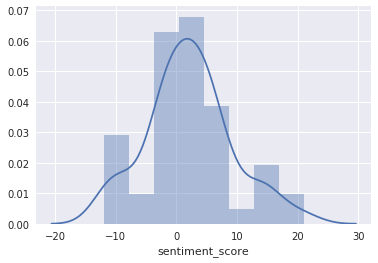

In [68]:
#histograms
warnings.filterwarnings('ignore')
sns.distplot(data_stats.sentiment_score);

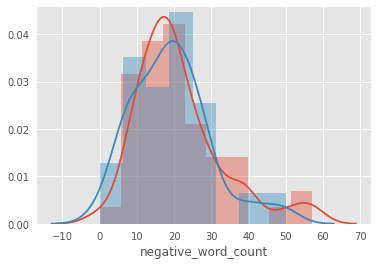

In [93]:
sns.distplot(data_stats.positive_word_count);sns.distplot(data_stats.negative_word_count);

The negative and postive term graphs are skewed right indicating that most documents are closer to neutral rather than the few of them extreme sentiment.

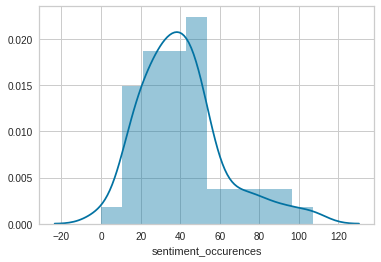

In [59]:
sns.distplot(data_stats.sentiment_occurences);

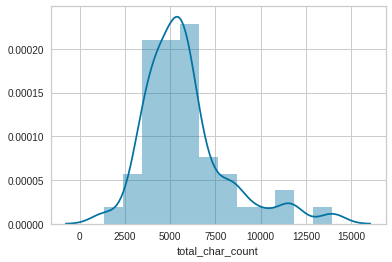

In [60]:
sns.distplot(data_stats.total_char_count);

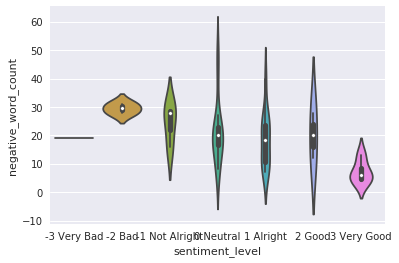

In [77]:
sns.violinplot(x = "sentiment_level", y= "negative_word_count", data=data_stats, order=["-3 Very Bad", "-2 Bad", "-1 Not Alright", "0 Neutral", "1 Alright", "2 Good", "3 Very Good"])

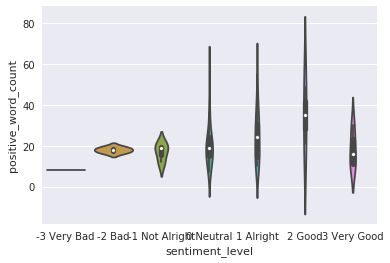

In [79]:
sns.violinplot(x = "sentiment_level", y= "positive_word_count", data=data_stats, order=["-3 Very Bad", "-2 Bad", "-1 Not Alright", "0 Neutral", "1 Alright", "2 Good", "3 Very Good"])

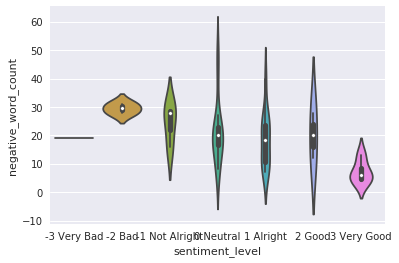

In [80]:
sns.violinplot(x = "sentiment_level", y= "negative_word_count", data=data_stats, order=["-3 Very Bad", "-2 Bad", "-1 Not Alright", "0 Neutral", "1 Alright", "2 Good", "3 Very Good"])

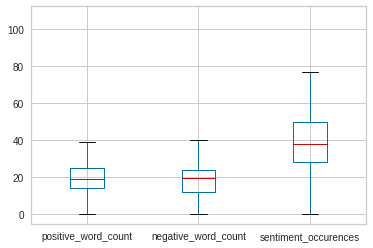

In [62]:
data_stats.boxplot(column=['positive_word_count', 'negative_word_count', 'sentiment_occurences'])

Since distrubtions or normal from the histograms we can use box plots to help visualize

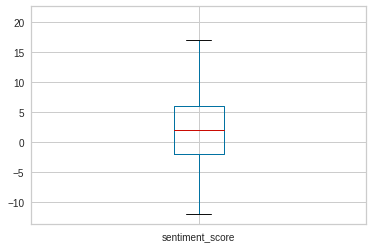

In [63]:
data_stats.boxplot(column=['sentiment_score'])

##### 3.1.2 Correlations

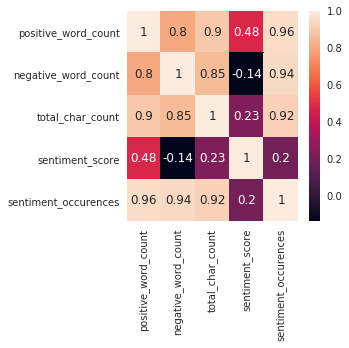

In [64]:
#heatmap
#interesting note that the sentiment score is more related to the negative occurences than positive. Character count related to negativity
drop = data_stats.drop(columns= ["sentiment_class"])
cmap = sns.set(style="darkgrid")
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(drop.corr(), cmap=cmap, annot=True)
f.tight_layout()

Notice that the sentiment score is more related to negative occurences than positive. Meaning most positves terms are cancel out by negatives. The longer the text, the very high chance(.9) there is more sentiment occurences. Postive and negative terms occur together (.67). Sentiment score is more correlated to negative (-.55) then postive word count. Maybe postive words are usually canceld by negative ones. 

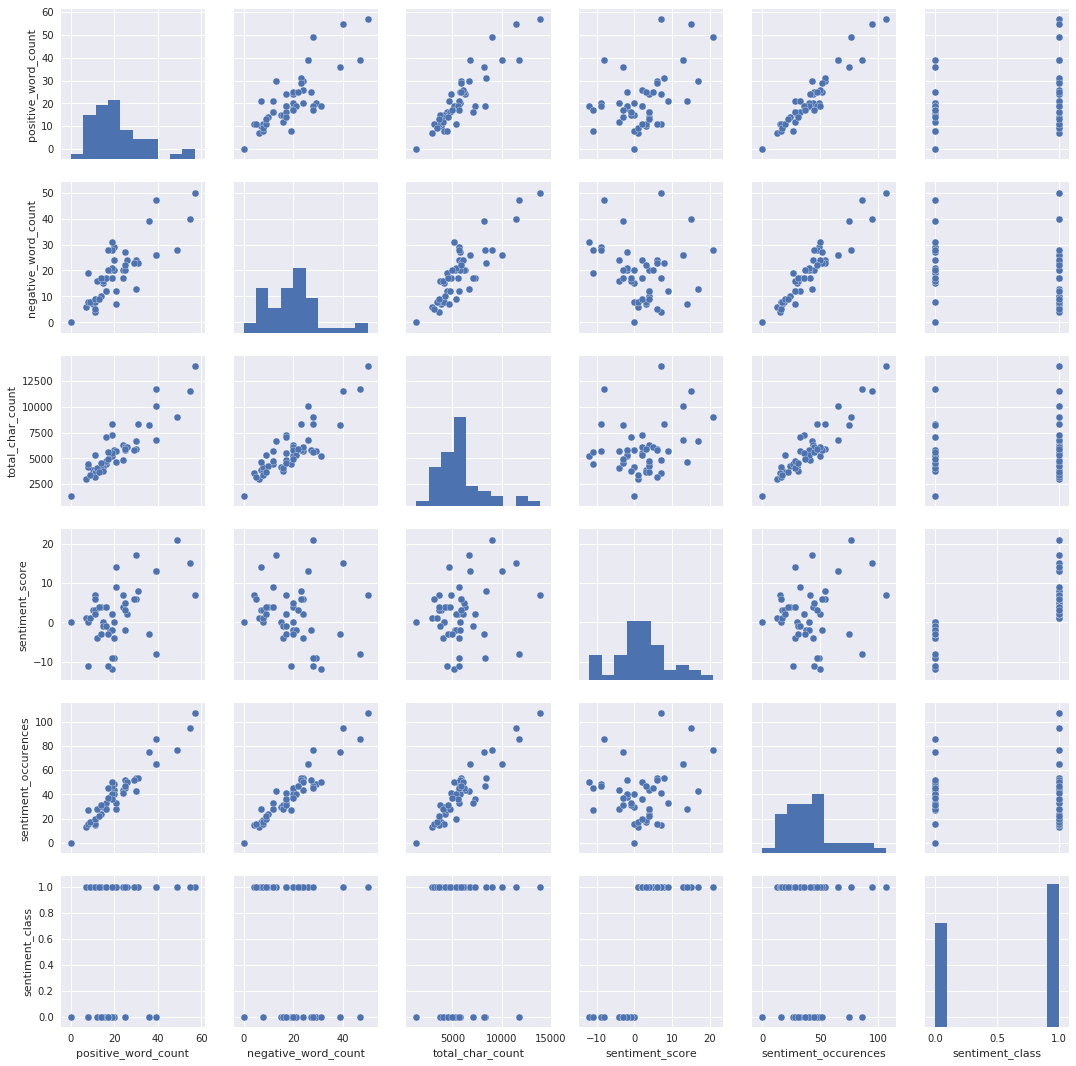

In [65]:
sns.pairplot(data_stats)

In general by looking at the sentiment score row it is actually not very preditable and is almost normal around 0. 

#### 3.2  Target classes

##### 3.2.1 Bar Chart by Level of Sentiment

In [84]:
df_grouped_sentiments = data_stats.groupby(by='sentiment_level')
for val,grp in df_grouped_sentiments:
    print('There were',len(grp),'reviews sentimental words rated', val)

df_grouped_sentiments.describe()

There were 1 reviews sentimental words rated -1 No Sentiment
There were 3 reviews sentimental words rated -1 Not Alright
There were 2 reviews sentimental words rated -2 Bad
There were 1 reviews sentimental words rated -3 Very Bad
There were 23 reviews sentimental words rated 0 Neutral
There were 14 reviews sentimental words rated 1 Alright
There were 2 reviews sentimental words rated 2 Good
There were 4 reviews sentimental words rated 3 Very Good


negative_word_count                                           \
                              count       mean        std   min    25%   50%   
sentiment_level                                                                
-1 No Sentiment                 1.0   0.000000        NaN   0.0   0.00   0.0   
-1 Not Alright                  3.0  24.333333   7.234178  16.0  22.00  28.0   
-2 Bad                          2.0  29.500000   2.121320  28.0  28.75  29.5   
-3 Very Bad                     1.0  19.000000        NaN  19.0  19.00  19.0   
0 Neutral                      23.0  21.043478  11.145640   6.0  16.50  20.0   
1 Alright                      14.0  18.357143   9.361189   7.0  10.50  18.5   
2 Good                          2.0  20.000000  11.313708  12.0  16.00  20.0   
3 Very Good                     4.0   7.250000   4.031129   4.0   4.75   6.0   

                             positive_word_count              ...     \
                   75%   max               count       mean   ...      
sentiment_level                                               ...      
-1 No Sentiment   0.00   0.0                 1.0   0.000000   ...      
-1 Not Alright   28.50  29.0                 3.0  17.000000   ...      
-2 Bad           30.25  31.0                 2.0  18.000000   ...      
-3 Very Bad      19.00  19.0                 1.0   8.000000   ...      
0 Neutral        23.00  50.0                23.0  20.739130   ...      
1 Alright        23.75  40.0                14.0  25.142857   ...      
2 Good           24.00  28.0                 2.0  35.000000   ...      
3 Very Good       8.50  13.0                 4.0  18.250000   ...      

                sentiment_score       total_char_count               \
                            75%   max            count         mean   
sentiment_level                                                       
-1 No Sentiment            0.00   0.0              1.0  1357.000000   
-1 Not Alright            -6.50  -4.0              3.0  6058.333333   
-2 Bad                   -11.25 -11.0              2.0  5421.000000   
-3 Very Bad              -11.00 -11.0              1.0  4415.000000   
0 Neutral                  2.00   7.0             23.0  6026.565217   
1 Alright                  7.75  15.0             14.0  6008.500000   
2 Good                    18.00  21.0              2.0  7371.500000   
3 Very Good               14.75  17.0              4.0  4517.500000   

                                                                         
                         std     min      25%     50%      75%      max  
sentiment_level                                                          
-1 No Sentiment          NaN  1357.0  1357.00  1357.0  1357.00   1357.0  
-1 Not Alright   2156.876059  4090.0  4905.50  5721.0  7042.50   8364.0  
-2 Bad            295.570635  5212.0  5316.50  5421.0  5525.50   5630.0  
-3 Very Bad              NaN  4415.0  4415.00  4415.0  4415.00   4415.0  
0 Neutral        2498.750685  2957.0  4746.00  5527.0  6210.50  13947.0  
1 Alright        2433.314256  3656.0  4311.75  5345.0  6625.50  11493.0  
2 Good           2373.757464  5693.0  6532.25  7371.5  8210.75   9050.0  
3 Very Good      1559.224059  3172.0  3494.50  4114.0  5137.00   6670.0  

[8 rows x 48 columns]

No sentiment word occurence than increase values from there

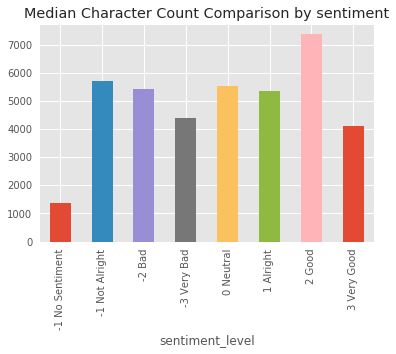

In [85]:
#grouped bar charts for both
plt.style.use('ggplot')

character_count = df_grouped_sentiments.total_char_count.median()
ax = character_count.plot(kind='bar')
plt.title('Median Character Count Comparison by sentiment')
plt.show()

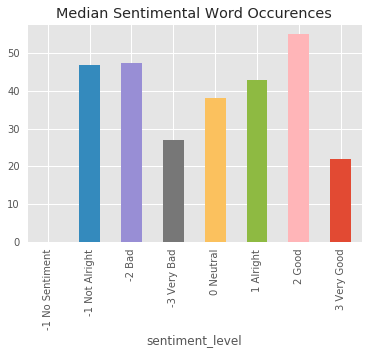

In [86]:
sentiment_occurences = df_grouped_sentiments.sentiment_occurences.median()
ax = sentiment_occurences.plot(kind='bar')
plt.title('Median Sentimental Word Occurences')
plt.show()

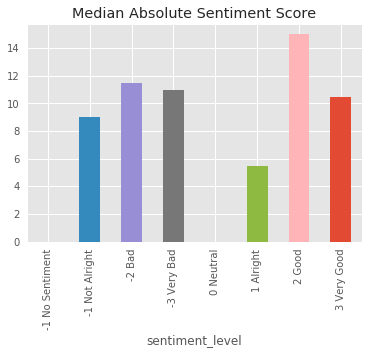

In [87]:
sentiment_score = abs(df_grouped_sentiments.sentiment_score.median())
ax = sentiment_score.plot(kind='bar')
plt.title('Median Absolute Sentiment Score')
plt.show()

surprisingly most reviews were neutral. This is probabl because they are by professionals and as a result have less emotional bias. only 4 had no sentimental words at all. The negative setiment score one had greater sentiment words numbers.

###### 3.2.2 Term Frequencies

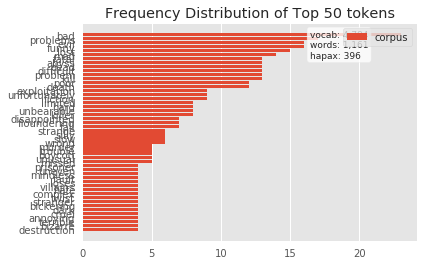

In [88]:
#term frquency charts
neg_features = neg_count_vect.get_feature_names()
visualizer = FreqDistVisualizer(features=neg_features)
visualizer.fit(neg_bag_words)
visualizer.poof()

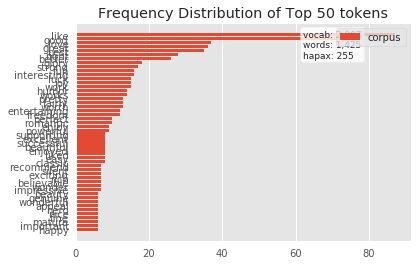

In [89]:
pos_features = pos_count_vect.get_feature_names()
visualizer = FreqDistVisualizer(features=pos_features)
visualizer.fit(pos_bag_words)
visualizer.poof()

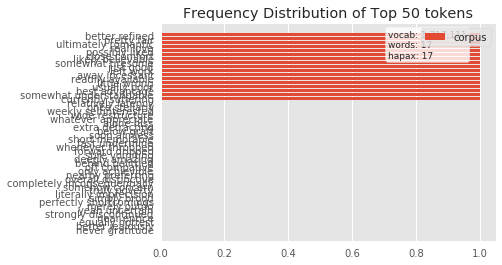

In [90]:
adv_bi_features = adv_bi_count_vect.get_feature_names()
visualizer = FreqDistVisualizer(features=adv_bi_features)
visualizer.fit(adv_bi_bag_words)
visualizer.poof()

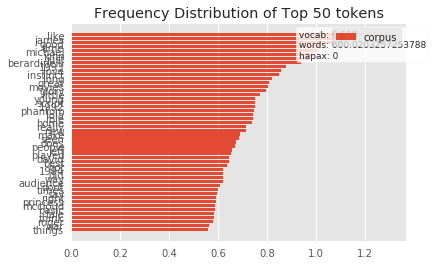

In [91]:
tfidf_features = tfidf_vect.get_feature_names()
visualizer = FreqDistVisualizer(features=tfidf_features)
visualizer.fit(tfidf_bag_words)
visualizer.poof()

Term frequency of postive negative and bigrams

<class 'str'>


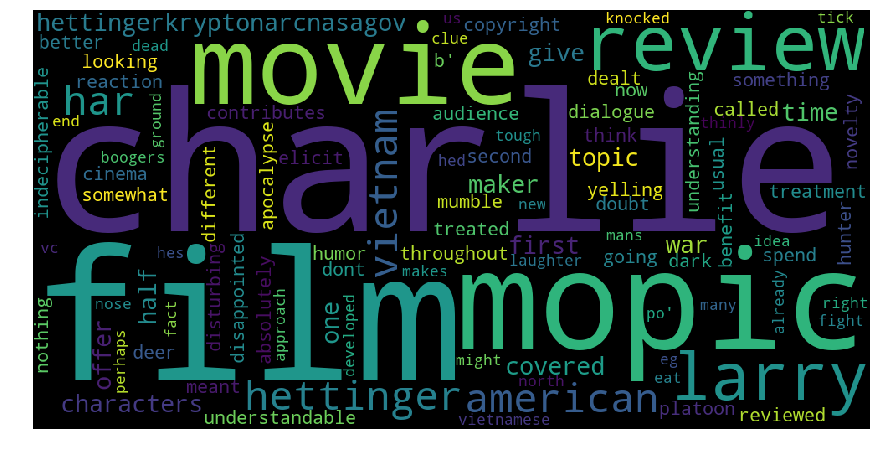

In [118]:
very_good_docs = data_stats.loc[data_stats['sentiment_level'] == "3 Very Good"].index.tolist()
very_good_docs


[9, 20, 22, 30]

In [119]:
total_positive_words = []

for doc_num in very_good_docs:
    total_positive_words += neg_count_vect.inverse_transform(neg_bag_words[1])[0].tolist()

In [120]:
total_positive_words

['apathy',
 'bored',
 'funky',
 'noise',
 'overblown',
 'trashed',
 'unfortunately',
 'apathy',
 'bored',
 'funky',
 'noise',
 'overblown',
 'trashed',
 'unfortunately',
 'apathy',
 'bored',
 'funky',
 'noise',
 'overblown',
 'trashed',
 'unfortunately',
 'apathy',
 'bored',
 'funky',
 'noise',
 'overblown',
 'trashed',
 'unfortunately']

In [121]:
    from wordcloud import WordCloud
    import matplotlib.pyplot as plt

    #convert list to string and generate
    unique_string=total_positive_words
    print(type(unique_string))

    wordcloud = WordCloud(width = 1000, height = 500).generate(unique_string)
    plt.figure(figsize=(15,8))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.savefig("your_file_name"+".png", bbox_inches='tight')
    plt.show()
    plt.close()

<class 'list'>


TypeError: expected string or bytes-like object